In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter 
import datetime as dt
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',100)
pd.set_option('display.width', 500)


## EDA & Data Distribution

To start off, we present some basic plots and EDA that provide insights on the distribution of the features in the dataset. Along the way we also define functions that manipulate applicant information to simplify the analysis.

A quick note to bear: we found it advantageous to generate identical samples multiple times to gauge the variability in the models\' outputs. With such a strategy we repeated each sample 10 times, for a set of 4000 distinct applicants, totaling 40000 rows of data. In this synthetic dataset each feature was drawn independently from a random distribution.

In [13]:
df = pd.read_csv('data/audit-data.csv', keep_default_na=False)
df.head()

,applicant_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,role1,start1,end1,role2,start2,end2,role3,start3,end3,resume_score,prediction,jobref_id,group_idx
0,1,Illinois Institute of Technology,4.00,Master's,43004,F,0,0,0,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,8.91,1,5,1-36001
1,2,Brown University,3.28,Master's,43004,F,0,1,0,White,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5.52,1,5,2-36002
2,3,University of Chicago,3.42,Bachelor's,6520,M,1,1,1,Asian,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4.24,1,5,3-36003
3,4,Brown University,2.57,Master's,15213,F,0,0,0,Black,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,9.31,0,5,4-36004
4,5,University of Rhode Island,2.72,PhD,10001,N/A,N/A,1,N/A,Black,Junior Economist,12/20,N/A,N/A,N/A,N/A,N/A,N/A,N/A,7.81,0,5,5-36005


In [14]:
def string_to_date(datestr, dt_format="%m/%y"):
    return dt.datetime.strptime(datestr, dt_format)

def date_diff(start_date, end_date):
    return (end_date-start_date).days


def calc_exp(start_str, end_str):
    if pd.isna(start_str) or start_str=="N/A":
        return 0
    else:
        start_dt = string_to_date(start_str)
        
    if pd.isna(end_str) or end_str=="N/A":
        end_dt = dt.datetime.today()
    else:
        end_dt = string_to_date(end_str)
    
    exp = date_diff(start_dt, end_dt)
    return exp

vec_calc_exp = np.vectorize(calc_exp)


df['role1_exp'] = vec_calc_exp(df['start1'], df['end1'])
df['role2_exp'] = vec_calc_exp(df['start2'], df['end2'])
df['role3_exp'] = vec_calc_exp(df['start3'], df['end3'])
df['total_exp'] = (df['role1_exp']+df['role2_exp']+df['role3_exp'])//365
df['num_jobs'] = np.sum(df[['role1_exp','role2_exp','role3_exp']].values>0, axis=1)
df['exp_yrs'] = pd.cut(df['total_exp'], bins=[0,1,3,5,10,15,100], 
                       labels=['00-01 yr','01-03 yr','03-05 yr','05-10 yr','10-15 yr','15+ yr'],
                       include_lowest=True, right=False)


df.groupby(['exp_yrs','num_jobs']).agg({'applicant_id':'count'}).reset_index().\
rename(columns={'applicant_id':'Number of applications', 'exp_yrs':'Experience', 'num_jobs':'Number of jobs'}).\
pivot_table(index=['Number of jobs'], columns=['Experience'], aggfunc=sum, margins=True, margins_name='Total')


Number of applications                                                  
Experience                   00-01 yr 01-03 yr 03-05 yr 05-10 yr 10-15 yr 15+ yr  Total
Number of jobs                                                                         
0                                3280        0        0        0        0      0   3280
1                                   0     6800     3320        0        0      0  10120
2                                   0     3520     3340        0        0      0   6860
3                                   0        0     3120    10160     3510   2950  19740
Total                            3280    10320     9780    10160     3510   2950  40000

The table above shows the distribution of application profiles. 3280 applications demonstrate no job history and have less than 1 year of experience. Likewise 10,320 demonstrate some job history but less than 3 years of work experience. The purpose of setting such a distribution was to ensure that different applicant profiles are well represented in our dataset.

Similarly, with sensitive features like gender and ethnicity, we have tried to achieve a rather uniform distribution. The same is shown below.

In [15]:
df.groupby(['gender','ethnicity']).agg({'applicant_id':'count'}).reset_index().\
rename(columns={'applicant_id':'Number of applications', 'gender':'Gender', 'ethnicity':'Ethnicity'}).\
pivot_table(index=['Gender'], columns=['Ethnicity'], aggfunc=sum, margins=True, margins_name='Total')


Number of applications                                                    
Ethnicity                  Asian Black Native American Pacific Islander White  Total
Gender                                                                              
F                           2780  2830            2650             2890  2610  13760
M                           2480  2780            2670             2620  2520  13070
N/A                         2710  2650            2500             2640  2670  13170
Total                       7970  8260            7820             8150  7800  40000

Finally, we look at the distribution of degrees and GPA. It's clear from the graphs below that degrees are distributed uniformly, while GPA is built from a normal distribution, clipped at a GPA of 4.0. The details can be found in the datagenerator file that handles generation of the synthetic dataset.

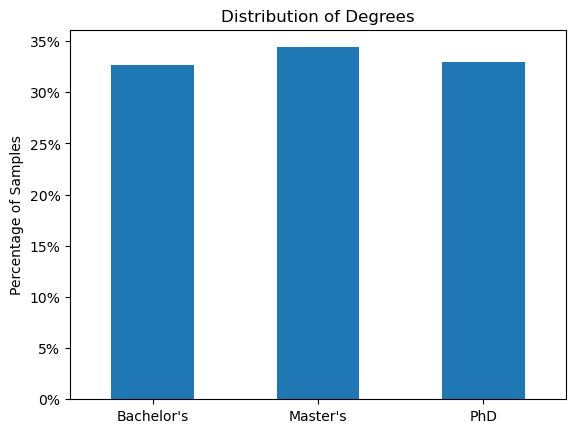

In [16]:
# create bar plot for degree in percentage
degree = ['Bachelor\'s', 'Master\'s', 'PhD']

temp_df_degree = df.groupby(by='degree').size()/df.groupby(by='degree').size().sum()
temp_df_degree.plot(kind='bar')

# rotate the x-axis labels
plt.xticks(rotation=0)

# add title and labels
plt.title('Distribution of Degrees')
plt.xlabel('')
plt.ylabel('Percentage of Samples')

plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))

# save as png
plt.savefig('plots/degree-dist.png', dpi=300)


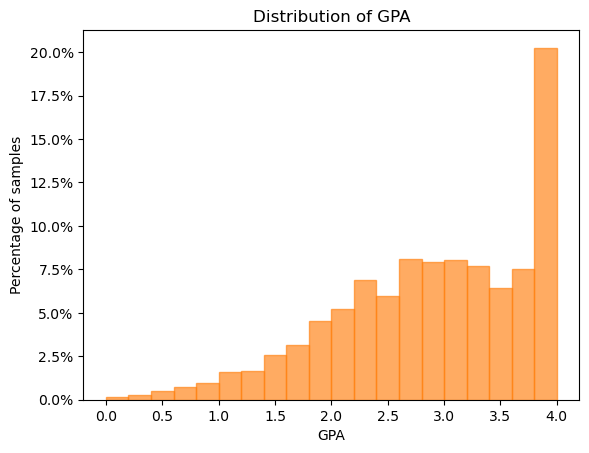

In [17]:
# show the distribution of GPA density in a histogram, remove grid and add n_bins
plt.hist(df['gpa'], weights=np.ones(len(df['gpa'])) / len(df['gpa']), 
         color='tab:orange', alpha=0.65, edgecolor='tab:orange', bins=20)

# add title and labels
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.ylabel('Percentage of samples')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# save as png
plt.savefig('plots/gpa-dist.png', dpi=300)

## Analysis

Now that we have completed describing different features of the synthetic dataset, and drawn some insights on the distributions, we'll move on to analyzing the resume scorer and candidate evaluator models. Bearing that each distinct sample is queried 10 times, we can find a mean score and mean selection rate for each of the 4000 distinct applicants. The dataframe `dedup_df` enables such an analysis scheme.

In [18]:
df['mean_selection_rate'] = df.groupby(['group_idx'])['prediction'].transform('mean')
df['mean_resume_score'] = df.groupby(['group_idx'])['resume_score'].transform('mean')
df['std_resume_score'] = df.groupby(['group_idx'])['resume_score'].transform(np.std)


dedup_df = df[['group_idx','jobref_id','school_name','gpa','degree','location','gender',
               'veteran_status','work_auth','disability','ethnicity','mean_selection_rate',
               'mean_resume_score','std_resume_score']].drop_duplicates()

score_bins = [0,1,2,3,4,5,6,7,8,9,10]
dedup_df['mean_resume_score_bins'] = pd.cut(dedup_df['mean_resume_score'], bins=score_bins,
                                            right=False, include_lowest=True)

gpa_bins = [0,3.0,4.0001]
dedup_df['gpa_bins'] = pd.cut(dedup_df['gpa'], bins=gpa_bins, right=False, include_lowest=True)
dedup_df.head()

,group_idx,jobref_id,school_name,gpa,degree,location,gender,veteran_status,work_auth,disability,ethnicity,mean_selection_rate,mean_resume_score,std_resume_score,mean_resume_score_bins,gpa_bins
0,1-36001,5,Illinois Institute of Technology,4.00,Master's,43004,F,0,0,0,Asian,0.5,4.522,3.608760,"[4, 5)","[3.0, 4.0)"
1,2-36002,5,Brown University,3.28,Master's,43004,F,0,1,0,White,0.4,6.544,2.735374,"[6, 7)","[3.0, 4.0)"
2,3-36003,5,University of Chicago,3.42,Bachelor's,6520,M,1,1,1,Asian,0.8,5.537,3.060000,"[5, 6)","[3.0, 4.0)"
3,4-36004,5,Brown University,2.57,Master's,15213,F,0,0,0,Black,0.4,5.544,3.143180,"[5, 6)","[0.0, 3.0)"
4,5-36005,5,University of Rhode Island,2.72,PhD,10001,N/A,N/A,1,N/A,Black,0.0,7.626,1.434063,"[7, 8)","[0.0, 3.0)"


In [19]:
def redo_colnames(colnames):
    


gender_group_df = dedup_df.groupby(['gender']).agg({'mean_resume_score':['mean'],
                                                    'mean_selection_rate':['mean']})


In [21]:
gender_group_df.columns

MultiIndex([(  'mean_resume_score', 'mean'),
            ('mean_selection_rate', 'mean')],
           )

In [11]:
import pandas as pd
import numpy as np

# Sample DataFrame with MultiIndex columns
arrays = [
    ['A', 'A', 'B', 'B'],
    ['one', 'two', 'one', 'two']
]
columns = pd.MultiIndex.from_arrays(arrays, names=('Upper', 'Lower'))
df = pd.DataFrame(np.random.randn(4, 4), columns=columns)

# Display the original DataFrame
print("Original DataFrame:")
df

Original DataFrame:


Upper         A                   B          
Lower       one       two       one       two
0     -0.391432 -0.570993 -1.557943 -1.822985
1     -1.496800  1.877101  1.166702  0.742154
2     -0.336124  0.756500 -0.619264  0.248675
3     -0.167214  0.242277 -0.048407  1.473332

## Appendix

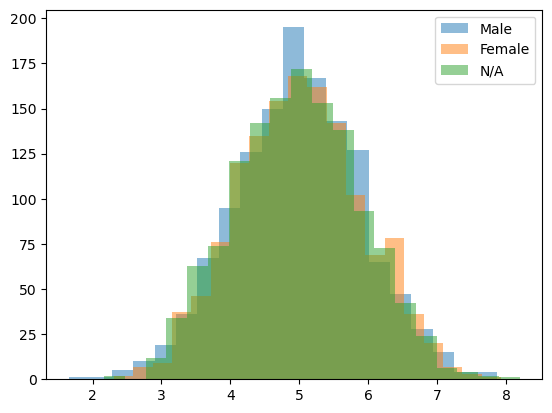

In [9]:
# show the distribution of mean resume score for each group_idx in a histogram, remove grid and add n_bins
n_bins = 20

plt.hist(df[df['gender']=='M'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='Male')
plt.hist(df[df['gender']=='F'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='Female')
plt.hist(df[df['gender']=='N/A'].groupby(['group_idx'])['resume_score'].mean(), n_bins, alpha=0.5, label='N/A')

plt.legend(loc='upper right')
plt.show()
